In [1]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib

DATA_DIR = "/Users/mgrsuraz/Downloads/Courses/DSDE/Project_Final/Health_project/processed_data/"
path = os.path.join(DATA_DIR, "health_features_2023.parquet")

features = pd.read_parquet(path)
features.tail()


,year,stateabbr,statedesc,locationname,locationid,totalpopulation,obesity_rate,diabetes_rate,mental_distress_rate,depression_rate
2953,2023,MI,Michigan,Monroe,26115,155045,40.6,12.3,19.4,28.0
2954,2023,LA,Louisiana,St. John the Baptist,22095,39592,41.8,17.2,19.9,24.6
2955,2023,KS,Kansas,Sherman,20181,5844,39.3,12.3,17.7,21.4
2956,2023,MD,Maryland,Harford,24025,264644,35.8,11.6,16.5,22.4
2957,2023,MO,Missouri,Butler,29023,41948,41.3,15.3,21.7,28.7


In [2]:
cols_features = [
    "obesity_rate",
    "diabetes_rate",
    "mental_distress_rate",
    "depression_rate",
]

X = features[cols_features].copy()

X_clean = X.dropna()

meta = features.loc[X_clean.index, [
    "stateabbr", "statedesc", "locationname", "totalpopulation"
]].reset_index(drop=True)

X_clean = X_clean.reset_index(drop=True)

X_clean.head(), meta.head()


(   obesity_rate  diabetes_rate  mental_distress_rate  depression_rate
 0          40.7           15.5                  20.2             26.8
 1          30.6           12.3                  18.7             24.7
 2          35.5           13.0                  15.6             18.6
 3          39.0           12.3                  19.2             26.0
 4          35.6           14.7                  18.8             25.8,
   stateabbr statedesc locationname  totalpopulation
 0        MO  Missouri        Worth             1907
 1        MT   Montana      Granite             3595
 2        NE  Nebraska       Harlan             3045
 3        MO  Missouri       Warren            37806
 4        MO  Missouri       Camden            44044)

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# number of clusters
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_scaled)

meta["cluster"] = clusters
for c in cols_features:
    meta[c] = X_clean[c]

meta.head()


,stateabbr,statedesc,locationname,totalpopulation,cluster,obesity_rate,diabetes_rate,mental_distress_rate,depression_rate
0,MO,Missouri,Worth,1907,1,40.7,15.5,20.2,26.8
1,MT,Montana,Granite,3595,0,30.6,12.3,18.7,24.7
2,NE,Nebraska,Harlan,3045,3,35.5,13.0,15.6,18.6
3,MO,Missouri,Warren,37806,0,39.0,12.3,19.2,26.0
4,MO,Missouri,Camden,44044,0,35.6,14.7,18.8,25.8


In [4]:
cluster_summary = (
    meta.groupby("cluster")
    .agg(
        n_counties=("locationname", "count"),
        avg_obesity=("obesity_rate", "mean"),
        avg_diabetes=("diabetes_rate", "mean"),
        avg_mental_distress=("mental_distress_rate", "mean"),
        avg_depression=("depression_rate", "mean")
    )
)

cluster_summary


,n_counties,avg_obesity,avg_diabetes,avg_mental_distress,avg_depression
cluster,,,,,
0,1304,37.754371,12.977301,18.256518,23.815337
1,627,40.430941,15.194737,21.040670,28.524083
2,375,42.778933,18.245067,19.923733,21.933600
3,651,32.191551,11.018894,16.343779,21.596160


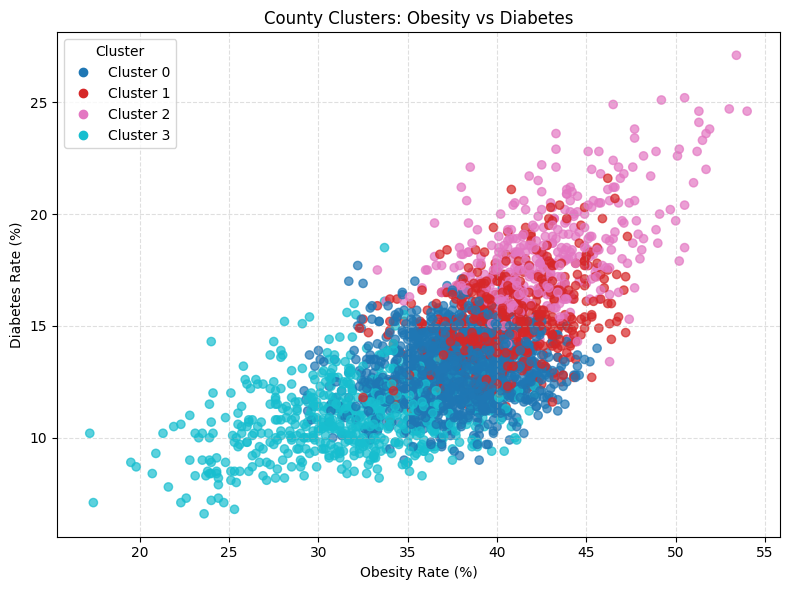

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# two features for visualization
x = meta["obesity_rate"]
y = meta["diabetes_rate"]
c = meta["cluster"]

plt.figure(figsize=(8,6))
scatter = plt.scatter(x, y, c=c, cmap="tab10", alpha=0.7)

plt.xlabel("Obesity Rate (%)")
plt.ylabel("Diabetes Rate (%)")
plt.title("County Clusters: Obesity vs Diabetes")

handles = []
labels = []
for cl in sorted(meta["cluster"].unique()):
    handles.append(
        plt.Line2D([], [], marker="o", linestyle="", color=scatter.cmap(scatter.norm(cl)))
    )
    labels.append(f"Cluster {cl}")
plt.legend(handles, labels, title="Cluster")

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Cluster 1 counties tend to have both high obesity and high diabetes, while Cluster 3 is lower on both.

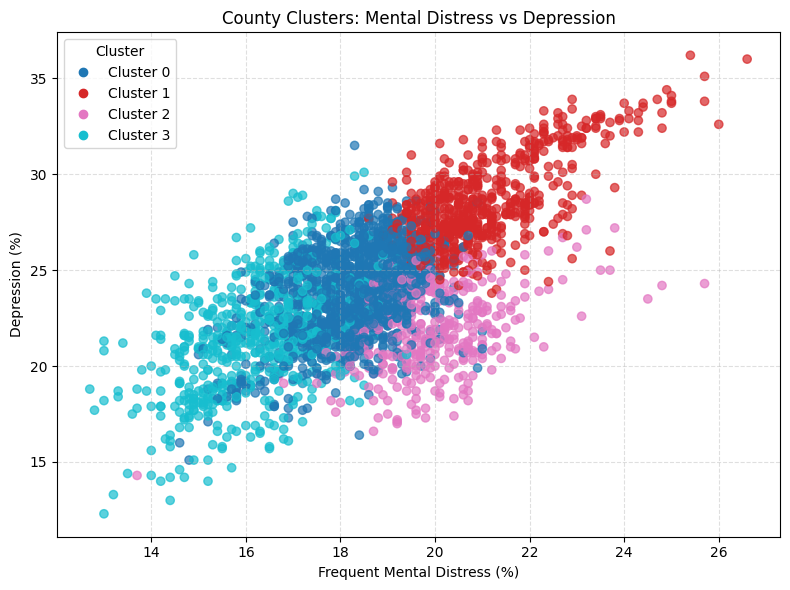

In [6]:
plt.figure(figsize=(8,6))

x2 = meta["mental_distress_rate"]
y2 = meta["depression_rate"]
c = meta["cluster"]

scatter2 = plt.scatter(x2, y2, c=c, cmap="tab10", alpha=0.7)

plt.xlabel("Frequent Mental Distress (%)")
plt.ylabel("Depression (%)")
plt.title("County Clusters: Mental Distress vs Depression")

handles = []
labels = []
for cl in sorted(meta["cluster"].unique()):
    handles.append(
        plt.Line2D([], [], marker="o", linestyle="", color=scatter2.cmap(scatter2.norm(cl)))
    )
    labels.append(f"Cluster {cl}")
plt.legend(handles, labels, title="Cluster")

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Clusters with high mental distress also tend to have more short sleep.

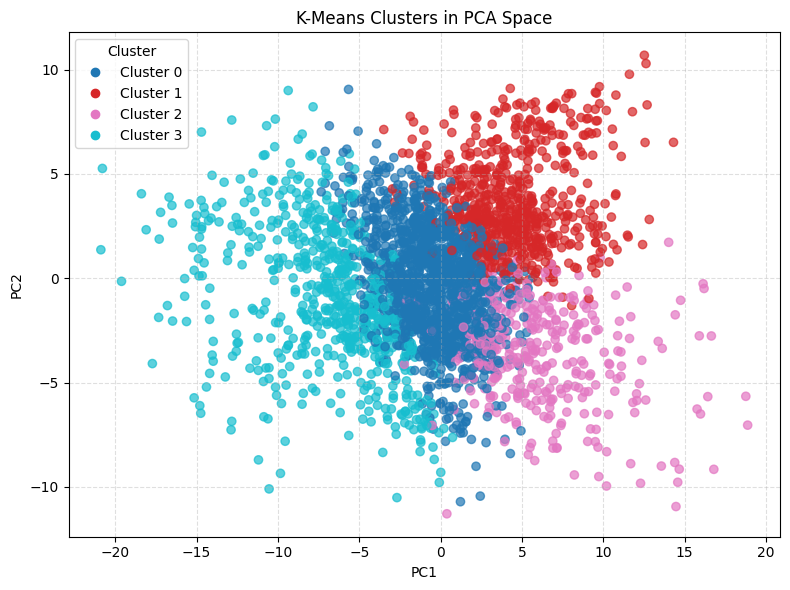

In [7]:
# PCA 2D visualization
from sklearn.decomposition import PCA

feature_cols = [
    "obesity_rate",
    "diabetes_rate",
    "mental_distress_rate",
    "depression_rate",
]

X_vis = meta[feature_cols].dropna()
clusters_vis = meta.loc[X_vis.index, "cluster"]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis)

plt.figure(figsize=(8,6))
scatter3 = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters_vis, cmap="tab10", alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters in PCA Space")

handles = []
labels = []
for cl in sorted(clusters_vis.unique()):
    handles.append(
        plt.Line2D([], [], marker="o", linestyle="", color=scatter3.cmap(scatter3.norm(cl)))
    )
    labels.append(f"Cluster {cl}")
plt.legend(handles, labels, title="Cluster")

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


We project counties into a 2D PCA space and color by K-Means cluster to visualize separation between health profiles.